# **1. 주식 예측에 도전해보자**

### **STEP 1 : 시계열 데이터 준비**



*   칼럼 종류: Date, Open, High, Low, Close, Adj Close, Volume
*   날짜별로 시작가(Open), 최고가(High), 최저가(Low), 종가(Close), 수정종가(Adj Close), 거래량(Volume)이 저장되어 있는 것을 확인할 수 있습니다.
*   우리는 종가(Close)만 사용하겠습니다. (주식 시장은 정해진 시간 동안만 거래가 가능합니다. 종가란 하루의 장이 마감하였을 때의 가격입니다.)



In [349]:
import pandas
import sklearn
import statsmodels
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [350]:
df = pd.read_csv('005930.KS.csv', index_col='Date', parse_dates=True)
ts = df['Close']

ts.head()

Date
2020-05-18    48800.0
2020-05-19    50300.0
2020-05-20    50000.0
2020-05-21    49950.0
2020-05-22    48750.0
Name: Close, dtype: float64

### **STEP 2 : 각종 전처리 수행**



*   결측치 처리



In [351]:
ts = ts.interpolate(methon='time')
ts[ts.isna()]

Series([], Name: Close, dtype: float64)

*   로그 변환

In [352]:
ts_log = np.log(ts)

### **STEP 3 : 시계열 안정성 분석**



*   정성적 그래프 분석



In [353]:
def plot_rolling_statistics(timeseries, window=12):
    
    rolmean = timeseries.rolling(window=window).mean()
    rolstd = timeseries.rolling(window=window).std()

    orig = plt.plot(timeseries, color='blue',label='Original')    
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label='Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)

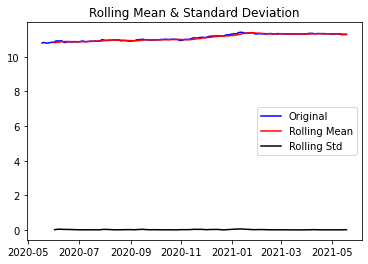

In [354]:
plot_rolling_statistics(ts_log, window=12)

*   정량적 Augmented Dicky-Fuller Test

In [355]:
from statsmodels.tsa.stattools import adfuller

def augmented_dickey_fuller_test(timeseries):
    dftest = adfuller(timeseries, autolag='AIC')  
    
    print('Results of Dickey-Fuller Test:')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)' % key] = value
    print(dfoutput)

In [356]:
augmented_dickey_fuller_test(ts_log)

Results of Dickey-Fuller Test:
Test Statistic                  -1.383525
p-value                          0.590149
#Lags Used                       0.000000
Number of Observations Used    249.000000
Critical Value (1%)             -3.456888
Critical Value (5%)             -2.873219
Critical Value (10%)            -2.572994
dtype: float64


*   시계열 분해(Time Series Decomposition)

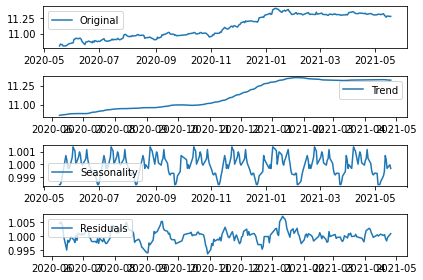

In [357]:
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(ts_log, model='multiplicative', period = 30) 

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

plt.subplot(411)
plt.plot(ts_log, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()



*   Residual 안정성 확인



In [358]:
residual.dropna(inplace=True)
augmented_dickey_fuller_test(residual)

Results of Dickey-Fuller Test:
Test Statistic                -6.187586e+00
p-value                        6.234854e-08
#Lags Used                     9.000000e+00
Number of Observations Used    2.100000e+02
Critical Value (1%)           -3.461879e+00
Critical Value (5%)           -2.875404e+00
Critical Value (10%)          -2.574159e+00
dtype: float64


### **STEP 4 : 학습, 테스트 데이터셋 생성**



*   학습, 테스트 데이터셋 분리



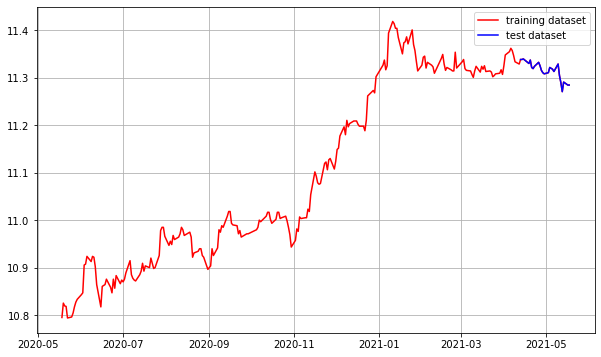

In [359]:
train_data, test_data = ts_log[:int(len(ts_log)*0.9)], ts_log[int(len(ts_log)*0.9):]
plt.figure(figsize=(10,6))
plt.grid(True)
plt.plot(ts_log, c='r', label='training dataset')
plt.plot(test_data, c='b', label='test dataset')
plt.legend()

### **STEP 5 : 적정 ARIMA 모수 찾기**



*   ACF, PACF 그려보기 -> p,q 구하기



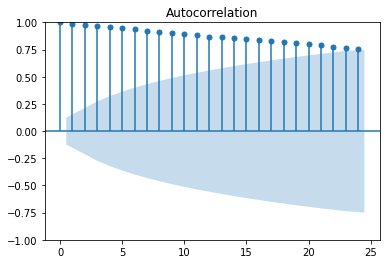

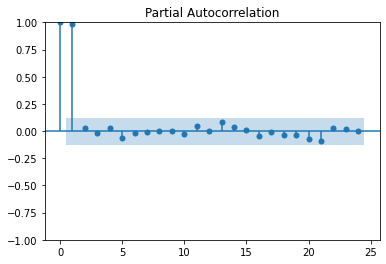

In [360]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plot_acf(ts_log)
plot_pacf(ts_log, method='ywm')
plt.show()



*   차분 안정성 확인 -> d 구하기



Results of Dickey-Fuller Test:
Test Statistic                -1.553699e+01
p-value                        2.183738e-28
#Lags Used                     0.000000e+00
Number of Observations Used    2.480000e+02
Critical Value (1%)           -3.456996e+00
Critical Value (5%)           -2.873266e+00
Critical Value (10%)          -2.573019e+00
dtype: float64
Results of Dickey-Fuller Test:
Test Statistic                -1.029320e+01
p-value                        3.525823e-18
#Lags Used                     7.000000e+00
Number of Observations Used    2.400000e+02
Critical Value (1%)           -3.457894e+00
Critical Value (5%)           -2.873659e+00
Critical Value (10%)          -2.573229e+00
dtype: float64


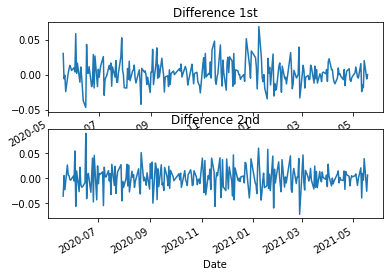

In [361]:
diff_1 = ts_log.diff(periods=1).iloc[1:]
plt.subplot(211)
diff_1.plot(title='Difference 1st')

augmented_dickey_fuller_test(diff_1)

diff_2 = diff_1.diff(periods=1).iloc[1:]
plt.subplot(212)
diff_2.plot(title='Difference 2nd')

augmented_dickey_fuller_test(diff_2)

### **STEP 6 : ARIMA 모델 훈련과 테스트**



*   ARIMA 모델 빌드와 훈련



In [362]:
import warnings
warnings.filterwarnings('ignore')

from statsmodels.tsa.arima.model import ARIMA

model = ARIMA(train_data, order=(2,0,1))
fitted_m = model.fit()

print(fitted_m.summary())

                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                  225
Model:                 ARIMA(2, 0, 1)   Log Likelihood                 583.361
Date:                Wed, 04 May 2022   AIC                          -1156.722
Time:                        20:22:48   BIC                          -1139.642
Sample:                             0   HQIC                         -1149.828
                                - 225                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         11.0896      0.129     86.277      0.000      10.838      11.342
ar.L1          0.7739      1.821      0.425      0.671      -2.796       4.344
ar.L2          0.2191      1.811      0.121      0.9

* 모델 테스트 및 플로팅

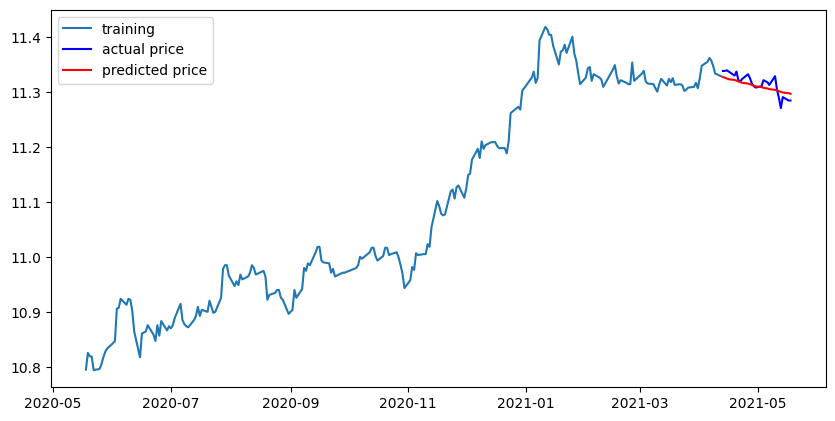

In [363]:
fc = fitted_m.forecast(len(test_data), alpah=0.05)
fc = np.array(fc)

fc_series = pd.Series(fc, index=test_data.index)

plt.figure(figsize=(10,5), dpi=100)
plt.plot(train_data, label='training')
plt.plot(test_data, c='b', label='actual price')
plt.plot(fc_series, c='r', label='predicted price')
plt.legend()
plt.show()

* 최종 예측 모델 정확도 측정(MAPE)

In [364]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math

mse = mean_squared_error(np.exp(test_data), np.exp(fc))
print('MSE: ', mse)

mae = mean_absolute_error(np.exp(test_data), np.exp(fc))
print('MAE: ', mae)

rmse = math.sqrt(mean_squared_error(np.exp(test_data), np.exp(fc)))
print('RMSE: ', rmse)

mape = np.mean(np.abs(np.exp(fc) - np.exp(test_data))/np.abs(np.exp(test_data)))
print('MAPE: {:.2f}%'.format(mape*100))

MSE:  1048973.6014239227
MAE:  843.757953150685
RMSE:  1024.1941229200268
MAPE: 1.03%


### **STEP 7 : 다른 주식 종목 예측해 보기**

* 데이터 준비

In [365]:
df = pd.read_csv('GOOG.csv', index_col='Date', parse_dates=True)
ts = df['Close']

ts.head()

Date
2021-05-04    2354.250000
2021-05-05    2356.739990
2021-05-06    2381.350098
2021-05-07    2398.689941
2021-05-10    2341.659912
Name: Close, dtype: float64

* 결측치 처리

In [366]:
ts = ts.interpolate(methon='time')
ts[ts.isna()]

Series([], Name: Close, dtype: float64)

* 로그 변환

In [367]:
ts_log = np.log(ts)

* 정성적 그래프 분서

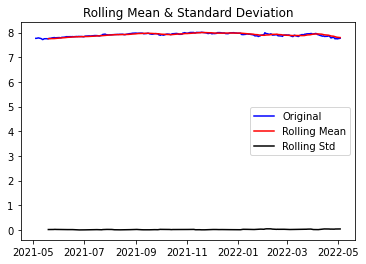

In [368]:
plot_rolling_statistics(ts_log, window=12)

* 정량적 Augmented Dicky-Fuller Test

In [369]:
augmented_dickey_fuller_test(ts_log)

Results of Dickey-Fuller Test:
Test Statistic                  -1.950151
p-value                          0.308848
#Lags Used                       0.000000
Number of Observations Used    252.000000
Critical Value (1%)             -3.456569
Critical Value (5%)             -2.873079
Critical Value (10%)            -2.572919
dtype: float64


* 시계열 분해(Time Series Decomposition)

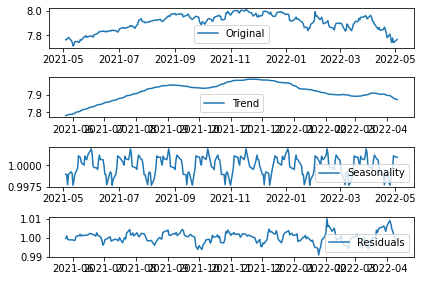

In [370]:
decomposition = seasonal_decompose(ts_log, model='multiplicative', period = 30) 

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

plt.subplot(411)
plt.plot(ts_log, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()

* Residual 안정성 확인

In [371]:
residual.dropna(inplace=True)
augmented_dickey_fuller_test(residual)

Results of Dickey-Fuller Test:
Test Statistic                -5.748691e+00
p-value                        6.036970e-07
#Lags Used                     5.000000e+00
Number of Observations Used    2.170000e+02
Critical Value (1%)           -3.460849e+00
Critical Value (5%)           -2.874953e+00
Critical Value (10%)          -2.573919e+00
dtype: float64


* 데이터셋 분리

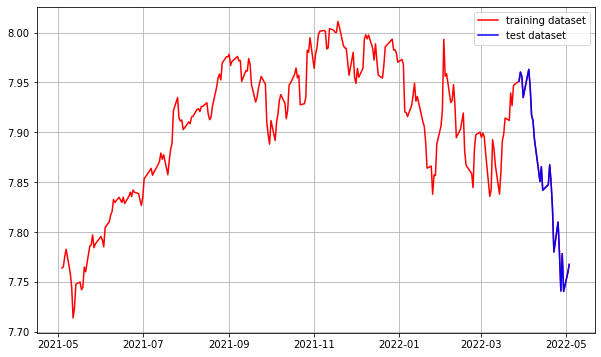

In [372]:
train_data, test_data = ts_log[:int(len(ts_log)*0.9)], ts_log[int(len(ts_log)*0.9):]
plt.figure(figsize=(10,6))
plt.grid(True)
plt.plot(ts_log, c='r', label='training dataset')
plt.plot(test_data, c='b', label='test dataset')
plt.legend()

* 적정 ARIMA 모수 찾기 (1) p, q

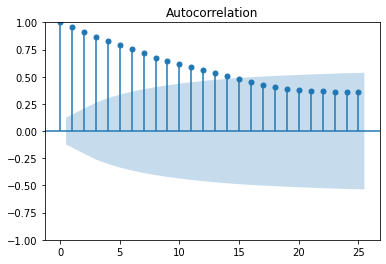

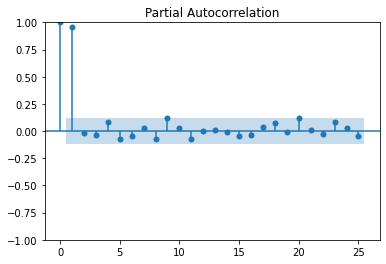

In [373]:
plot_acf(ts_log)
plot_pacf(ts_log)
plt.show()

* 적정 ARIMA 모수 찾기 (2) d

Results of Dickey-Fuller Test:
Test Statistic                -1.616898e+01
p-value                        4.385167e-29
#Lags Used                     0.000000e+00
Number of Observations Used    2.510000e+02
Critical Value (1%)           -3.456674e+00
Critical Value (5%)           -2.873125e+00
Critical Value (10%)          -2.572944e+00
dtype: float64
Results of Dickey-Fuller Test:
Test Statistic                -8.210380e+00
p-value                        6.843949e-13
#Lags Used                     1.200000e+01
Number of Observations Used    2.380000e+02
Critical Value (1%)           -3.458128e+00
Critical Value (5%)           -2.873762e+00
Critical Value (10%)          -2.573283e+00
dtype: float64
Results of Dickey-Fuller Test:
Test Statistic                -9.221816e+00
p-value                        1.771601e-15
#Lags Used                     1.600000e+01
Number of Observations Used    2.330000e+02
Critical Value (1%)           -3.458731e+00
Critical Value (5%)           -2.874026e+

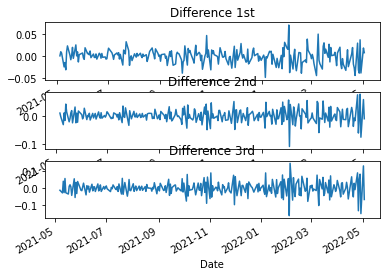

In [374]:
diff_1 = ts_log.diff(periods=1).iloc[1:]
plt.subplot(311)
diff_1.plot(title='Difference 1st')

augmented_dickey_fuller_test(diff_1)

diff_2 = diff_1.diff(periods=1).iloc[1:]
plt.subplot(312)
diff_2.plot(title='Difference 2nd')

augmented_dickey_fuller_test(diff_2)

diff_3 = diff_2.diff(periods=1).iloc[1:]
plt.subplot(313)
diff_3.plot(title='Difference 3rd')

augmented_dickey_fuller_test(diff_3)

* ARIMA 모델 빌드와 훈련

In [375]:
from statsmodels.tsa.arima.model import ARIMA

model = ARIMA(train_data, order=(2,3,0))
fitted_m = model.fit()

print(fitted_m.summary())

                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                  227
Model:                 ARIMA(2, 3, 0)   Log Likelihood                 505.559
Date:                Wed, 04 May 2022   AIC                          -1005.118
Time:                        20:22:50   BIC                           -994.883
Sample:                             0   HQIC                         -1000.987
                                - 227                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.9863      0.048    -20.455      0.000      -1.081      -0.892
ar.L2         -0.4113      0.045     -9.079      0.000      -0.500      -0.323
sigma2         0.0006    4.8e-05     13.310      0.0

* 모델 테스트 및 플로팅

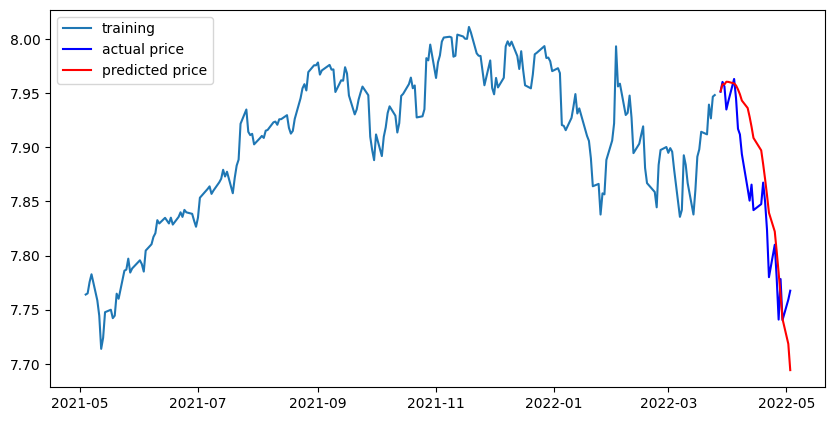

In [376]:
fc = fitted_m.forecast(len(test_data), alpah=0.05)
fc = np.array(fc)

fc_series = pd.Series(fc, index=test_data.index)

plt.figure(figsize=(10,5), dpi=100)
plt.plot(train_data, label='training')
plt.plot(test_data, c='b', label='actual price')
plt.plot(fc_series, c='r', label='predicted price')
plt.legend()
plt.show()

* 최종 예측 모델 정확도 측정(MAPE)

In [377]:
mse = mean_squared_error(np.exp(test_data), np.exp(fc))
print('MSE: ', mse)

mae = mean_absolute_error(np.exp(test_data), np.exp(fc))
print('MAE: ', mae)

rmse = math.sqrt(mean_squared_error(np.exp(test_data), np.exp(fc)))
print('RMSE: ', rmse)

mape = np.mean(np.abs(np.exp(fc) - np.exp(test_data))/np.abs(np.exp(test_data)))
print('MAPE: {:.2f}%'.format(mape*100))

MSE:  10998.383026517688
MAE:  84.54656420396825
RMSE:  104.87317591509131
MAPE: 3.32%


# **2. 회고**

시계열 데이터의 여러 특징들과 그에 따른 데이터 분석 기법에 대해 공부할 수 있었다. 특히, 시계열 안정성 분석을 위해 'p-value'라는 개념을 사용한 'Augmented Dicky-Fuller Test'와 ARIMA 모델의 최적화 파라미터(p,d,q)를 구하는 과정이 흥미로웠다. 또한 이러한 분석을 통해 미래를 예측할 수 있다는 점에서 몸소 딥러닝의 강력함을 느낄 수 있었다.